### Problem Description

Write some details of the problem ... also mention the link of the dataset

### Import Packages

In [44]:
# Add environment Packages paths to conda
import os, sys
env_name = "food_review"
sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\Mohammed
[nltk_data]     saad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read Dataset

In [45]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 21.2 s


In [46]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [47]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [48]:
df_text = df_text.drop_duplicates()

In [49]:
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [50]:
df.to_csv('df_text')

### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [51]:
df_text['target'] = df_text.Score.apply(lambda x :0 if x < 3 else 1)

#### Plot Countplot for target Variable

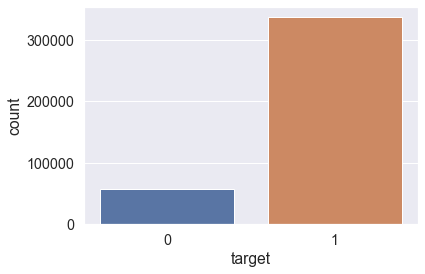

In [52]:
ax = sns.countplot(x=df_text['target'])

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [53]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.loc[df_pos.index], df_text[df_text.target == 0]])

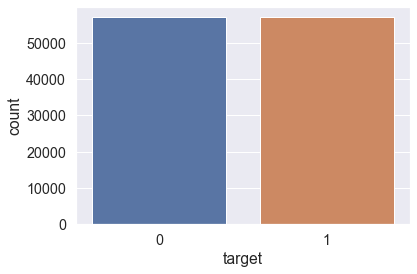

In [54]:
ax = sns.countplot(x=df_text_balanced['target'])

### Text Pre-Processing

In [55]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

## removeing stop words and extract only text

In [56]:
df_text_balanced["Text_Clean"] = df_text_balanced["Text"].str.lower()
df_text_balanced["Text_Clean"] = df_text_balanced["Text_Clean"].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
df_text_balanced["Text_Clean"] = df_text_balanced["Text_Clean"].apply(lambda elem: re.sub(r"\d+", "", elem))
df_text_balanced['Text_Clean'] = df_text_balanced['Text_Clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_text_balanced.head()

,Text,Score,target,Text_Clean
544979,My wife has a glass each and every day.This is...,5,1,wife glass every daythis best k cup iced coffe...
37067,"We refer to these bones as ""the baby sitters"" ...",5,1,refer bones baby sitters since labs spend hour...
310681,"These were so good, I keep stealing one from m...",5,1,good keep stealing one daughter loves medicina...
127632,this is a high quality Matcha which is very sm...,4,1,high quality matcha smooth tastes great bitter...
553610,The product was an excellent value but the shi...,4,1,product excellent value shipment took forever ...


In [57]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Tokens

In [58]:
df_text_balanced['Tokens'] = df_text_balanced['Text_Clean'].apply(lambda x: word_tokenize(x))
df_text_balanced.head()

,Text,Score,target,Text_Clean,Tokens
544979,My wife has a glass each and every day.This is...,5,1,wife glass every daythis best k cup iced coffe...,"[wife, glass, every, daythis, best, k, cup, ic..."
37067,"We refer to these bones as ""the baby sitters"" ...",5,1,refer bones baby sitters since labs spend hour...,"[refer, bones, baby, sitters, since, labs, spe..."
310681,"These were so good, I keep stealing one from m...",5,1,good keep stealing one daughter loves medicina...,"[good, keep, stealing, one, daughter, loves, m..."
127632,this is a high quality Matcha which is very sm...,4,1,high quality matcha smooth tastes great bitter...,"[high, quality, matcha, smooth, tastes, great,..."
553610,The product was an excellent value but the shi...,4,1,product excellent value shipment took forever ...,"[product, excellent, value, shipment, took, fo..."


## Stemming

In [59]:
def word_stemmer(text):
    stem_text = [SnowballStemmer("english").stem(i) for i in text]
    return stem_text

str = " "
df_text_balanced['Stemmed Words'] = df_text_balanced['Tokens'].apply(lambda x: word_stemmer(x))
df_text_balanced['Stemmed Words'] = df_text_balanced['Stemmed Words'].apply(lambda x: str.join(x))
df_text_balanced.head()

,Text,Score,target,Text_Clean,Tokens,Stemmed Words
544979,My wife has a glass each and every day.This is...,5,1,wife glass every daythis best k cup iced coffe...,"[wife, glass, every, daythis, best, k, cup, ic...",wife glass everi daythi best k cup ice coffe t...
37067,"We refer to these bones as ""the baby sitters"" ...",5,1,refer bones baby sitters since labs spend hour...,"[refer, bones, baby, sitters, since, labs, spe...",refer bone babi sitter sinc lab spend hour che...
310681,"These were so good, I keep stealing one from m...",5,1,good keep stealing one daughter loves medicina...,"[good, keep, stealing, one, daughter, loves, m...",good keep steal one daughter love medicin smel...
127632,this is a high quality Matcha which is very sm...,4,1,high quality matcha smooth tastes great bitter...,"[high, quality, matcha, smooth, tastes, great,...",high qualiti matcha smooth tast great bitter o...
553610,The product was an excellent value but the shi...,4,1,product excellent value shipment took forever ...,"[product, excellent, value, shipment, took, fo...",product excel valu shipment took forev slow sh...


### Split Test & Training Data

In [60]:
X =df_text_balanced['Stemmed Words'].values
y =df_text_balanced['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [61]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X_train)
# transform on training data
X_train = vectorizer.transform(X_train)
# transform on testing data
X_test = vectorizer.transform(X_test)

In [62]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79917, 67634), (34251, 67634))

### Modelling

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [64]:
## initialize your Model
clf = RandomForestClassifier()
# Fit your Model on the Training Dataset
clf.fit(X_train,y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 84.17%


### Raw Instance Prediction

In [74]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = review
   # cleaner(review_c)
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction =clf.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [75]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [76]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [77]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [78]:
import pickle

In [104]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)

pickle.dump(clf, open('model.pkl', 'wb'))
pickle.dump(vectorizer, open('vect.pkl', 'wb'))
... ## Save tfidf-vectorizer

Ellipsis

### Load model Again and test them

In [105]:
loaded_model = pickle.load(open('model.pkl', 'rb'))
loaded_vect =  pickle.load(open('vect.pkl', 'rb'))

In [106]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [107]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework